In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

In [9]:
train_examples = 20225
test_examples = 2555
validation_examples = 2551
batch_size = 10

train_path = "data2019/train/"
valid_path = "data2019/validation/"
test_path = "data2019/test/"

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['Actinic Keratosis', 'Basal Cell Carcinoma', 'Benign Keratosis', 'Dermatofibroma', 'Melanocytic Nevus', 'Melanoma', 'Squamous Cell Carcinoma', 'Vascular Lesion'], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Actinic Keratosis', 'Basal Cell Carcinoma', 'Benign Keratosis', 'Dermatofibroma', 'Melanocytic Nevus', 'Melanoma', 'Squamous Cell Carcinoma', 'Vascular Lesion'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Actinic Keratosis', 'Basal Cell Carcinoma', 'Benign Keratosis', 'Dermatofibroma', 'Melanocytic Nevus', 'Melanoma', 'Squamous Cell Carcinoma', 'Vascular Lesion'], batch_size=32, shuffle=False)
    
imgs, labels = next(train_batches)

Found 20225 images belonging to 8 classes.
Found 2551 images belonging to 8 classes.
Found 2555 images belonging to 8 classes.


In [4]:
#model taken from analyticsvidhya website
#https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/

model = Sequential([
    # convolutional layer
    Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(224, 224, 3)),
    
    # convolutional layer
    Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    # flatten output of conv
    Flatten(),
    
    # hidden layer
    Dense(500, activation='relu'),
    Dropout(0.4),
    Dense(250, activation='relu'),
    Dropout(0.3),
    # output layer
    Dense(8, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 50)      1400      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 75)      33825     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 75)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 75)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 125)     84500     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 125)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 125)       0

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

filepath="models/best_model2019.h5"

#callback functions
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
log_csv = CSVLogger('my_logs2019.csv', separator=',', append=False)

#training the model 
history = model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=30,
    verbose=1,
    callbacks=[checkpoint, early_stop, reduceLR, log_csv],
    steps_per_epoch=train_examples // batch_size,
    validation_steps=validation_examples // batch_size,
    )

In [7]:
#plot model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
#plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Epoch 1/30
 633/2022 [========>.....................] - ETA: 17:08 - loss: 1.2620 - accuracy: 0.5517WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 60660 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 1.81693, saving model to models/best_model2019.h5
 633/2022 [========>.....................] - 569s 898ms/step - loss: 1.2620 - accuracy: 0.5517 - val_loss: 1.8169 - val_accuracy: 0.5304


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

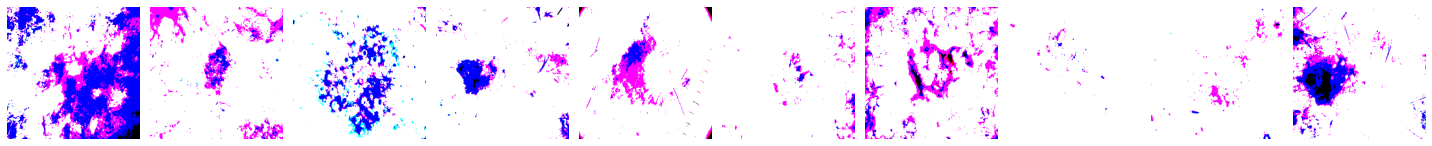

In [10]:
#plot images function 
#https://deeplizard.com/learn/video/14syUbL16k4
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes =axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)

In [6]:
predictions = model.predict(x=test_batches, verbose=0)
np.round(predictions)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Confusion matrix without normalization
[[   6   23   12    0   25   12    0    0]
 [   2  138   36    0  122   45    0    0]
 [   2   26   85    0   92   55    0    1]
 [   0    3    2    1   10    3    0    0]
 [   2   33   45    0 1070  166    0    2]
 [   2   24   34    0  167  224    0    0]
 [   2   17   13    0   15   12    0    0]
 [   0    5    0    0   12    1    0    9]]


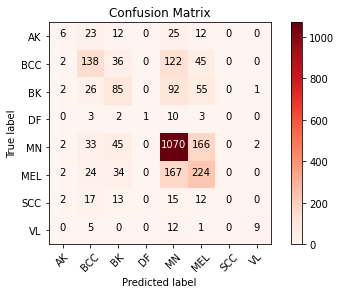

In [22]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

#function for confusion matrix taken from scikit-learn website
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm_plot_labels = ['AK', 'BCC', 'BK', 'DF', 'MN', 'MEL', 'SCC', 'VL'] #setting labels
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [3]:
model = load_model("models/best_model2019.h5")

In [5]:
print(model.evaluate(test_batches))

80/80 [==============================] - 54s 673ms/step - loss: 1.1467 - accuracy: 0.6000
[1.1466783285140991, 0.6000000238418579]


In [7]:
from sklearn.metrics import classification_report

y_pred=np.argmax(predictions, axis=-1)

#this gives precision, recall, f1 score and accuracy scores
print(classification_report(test_batches.classes, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.08      0.13        78
           1       0.51      0.40      0.45       343
           2       0.37      0.33      0.35       261
           3       1.00      0.05      0.10        19
           4       0.71      0.81      0.76      1318
           5       0.43      0.50      0.46       451
           6       0.00      0.00      0.00        59
           7       0.75      0.35      0.47        26

    accuracy                           0.60      2555
   macro avg       0.52      0.31      0.34      2555
weighted avg       0.58      0.60      0.58      2555



/home/sebastianthomas/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sebastianthomas/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sebastianthomas/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
#print(test_labels)
test_batches.class_indices

{'Actinic Keratosis': 0,
 'Basal Cell Carcinoma': 1,
 'Benign Keratosis': 2,
 'Dermatofibroma': 3,
 'Melanocytic Nevus': 4,
 'Melanoma': 5,
 'Squamous Cell Carcinoma': 6,
 'Vascular Lesion': 7}